# Trash

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import glob
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
#from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA

path_to_dataset = "../dataset/slides/RECHERCHE-015.npy"
path_to_labels = "../dataset/annotations/RECHERCHE-015_label-015.npy"

In [ ]:
class ImageHelpers:
    def __init__(self):
        self.sift_object = cv2.SIFT_create()

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return gray

    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return [keypoints, descriptors]

In [ ]:
class Descriptors:
    def __init__(self, dataset):
        self.dataset = dataset
        self.im_helper = ImageHelpers()

    def GetFeatures(self):
        descriptor_list = list()
        #for word, imlist in self.dataset:
        for image in self.dataset:
            _, des = self.im_helper.features(image)
            if des is None:
                continue
            descriptor_list.append(des)
        return descriptor_list

In [ ]:
# Data reshape
#dataset = np.load(path_to_dataset)[0:500]
datax = result.reshape(-1, 200*200*3)

In [ ]:
#dataset = np.load(path_to_dataset)[0:50]
#descriptor = Descriptors(dataset)
#descriptors_list_train = descriptor.GetFeatures()
#descriptors_train = np.concatenate(descriptors_list_train, axis=0)

In [ ]:
#len(descriptors_train[0])

128

In [ ]:
#K-Means
n_clusters = 10
kmeans = KMeans(n_clusters = n_clusters, random_state = 0, n_init='auto')
kmeans_pred_train = kmeans.fit_predict(datax)

In [ ]:
kmeans_pred_train

In [ ]:
# Plots
def plt_image(image, label):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(label)
    # Mostra i subplot affiancati
    plt.show()

In [ ]:
maschera = np.where(kmeans_pred_train == 1)
len(maschera[0])

6

In [ ]:
for i in range(0, len(maschera[0])):
  plt_image(dataset[maschera[0][i]], kmeans_pred_train[maschera[0][i]])

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


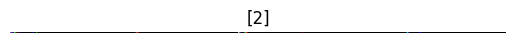

In [ ]:
for i in range(40,46):
  plt_image(dataset[i], kmeans_pred_train[i])

<Axes: >

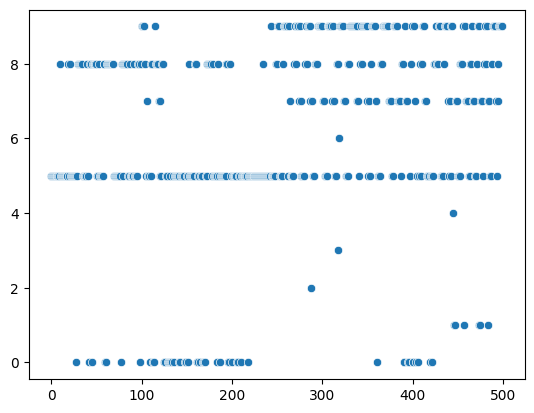

In [ ]:
import seaborn as sns

sns.scatterplot(data = kmeans_pred_train)

In [ ]:
x_data = [i for i in range(400*400*3)]
plt.scatter(x_data,kmeans.cluster_centers_[0], color = 'red',alpha=0.2)
plt.scatter(x_data,kmeans.cluster_centers_[1] , color = 'blue',alpha=0.2)
plt.scatter(x_data,kmeans.cluster_centers_[2] , color = 'green',alpha=0.2)

In [ ]:
kmeans.cluster_centers_[1]

array([240.91666667, 242.33333333, 240.66666667, ..., 229.91666667,
       225.70833333, 227.91666667])

# Extrapolate Glomeruli

In [3]:
path_to_dataset = "/content/drive/MyDrive/Polito/MLinAP/RECHERCHE-015.npy"
path_to_labels = "/content/drive/MyDrive/Polito/MLinAP/RECHERCHE-015_label.npy"

In [4]:
dataset = np.load(path_to_dataset)
labels = np.load(path_to_labels)

In [5]:
# Identification of images and labels with glomerulus
glomeruli = np.array([dataset[i] for i in range(len(dataset)) if (1 in labels[i])])
glomeruli_labels = np.array([labels[i] for i in range(len(dataset)) if (1 in labels[i])])

# Identification of images and labels without glomerulus
notGlomeruli = np.array([dataset[i] for i in range(len(dataset)) if not(1 in labels[i])])
notGlomeruli_labels = np.array([labels[i] for i in range(len(dataset)) if not(1 in labels[i])])

In [6]:
def glomeruli_crop(glomeruli, glomeruli_labels):
    result = []
    original_images = []
    original_labels = []
    result_labels = []

    for j in range(0, len(glomeruli)):
        num_labels, labels = cv2.connectedComponents(
            glomeruli_labels[j], connectivity=8)
        for i in range(1, num_labels):
            image = glomeruli[j]

            # Find row and column indices of pixels with value 1
            yrow, xcol = np.where(labels == i)

            # Calculate minimum and maximum row indices
            yrowmin = np.min(yrow)
            yrowmax = np.max(yrow)

            # Calculate minimum and maximum column indices
            xcolmin = np.min(xcol)
            xcolmax = np.max(xcol)

            # Calculate the size of the side of the square as the max between the height and the width
            side = max(yrowmax - yrowmin + 1, xcolmax - xcolmin + 1)
            if (side >= 20):
                # Adjust the bounding box to be square
                yrowmin = max(
                    0, yrowmin - (side - (yrowmax - yrowmin + 1)) // 2)
                yrowmax = yrowmin + side
                if yrowmax > image.shape[0]:
                    yrowmax = image.shape[0]
                    yrowmin = yrowmax - side
                xcolmin = max(
                    0, xcolmin - (side - (xcolmax - xcolmin + 1)) // 2)
                xcolmax = xcolmin + side
                if xcolmax > image.shape[1]:
                    xcolmax = image.shape[1]
                    xcolmin = xcolmax - side

                # Extract the square image from the original image
                cropped_image = image[yrowmin:yrowmax, xcolmin:xcolmax]

                # Calculate the proportion of glomerulus pixels in the cropped image
                cropped_label = labels[yrowmin:yrowmax, xcolmin:xcolmax] == i
                glomerulus_proportion = np.mean(cropped_label)

                # Only keep the image if the glomerulus proportion is above the threshold
                if glomerulus_proportion >= 0.6:
                    # Resize image
                    resized_image = cv2.resize(
                        cropped_image, (189, 189), interpolation=cv2.INTER_AREA)
                    cropped_label = labels[yrowmin:yrowmax, xcolmin:xcolmax]
                    resized_label = cv2.resize(
                        cropped_label, (189, 189), interpolation=cv2.INTER_NEAREST)

                    result.append(resized_image)
                    result_labels.append(resized_label)
                    original_images.append(image)
                    original_labels.append(labels)

    return np.array(result), np.array(result_labels), np.array(original_images), np.array(original_labels)

In [7]:
result, result_label, ori, ori_l = glomeruli_crop(glomeruli, glomeruli_labels)
result.shape


(61, 189, 189, 3)

In [ ]:
result = result.astype('float32') / 255

In [ ]:
# Save each image in a different file
for i in range(0, len(result)):
    cv2.imwrite(f'image{i}.jpg', result[i])


# VGG 19

In [8]:
import tensorflow as tf
vgg19 = tf.keras.applications.vgg19.VGG19(
            include_top=False,   # Exclusion of the last 3 layers
            weights='imagenet',
            # input_tensor=None,
            input_shape=(189,189,3),
            pooling='max',
            classifier_activation='relu'
        )

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg19.summary()

In [10]:
features = vgg19.predict(result)

2/2 [==============================] - 31s 14s/step


In [11]:
features.shape

(61, 512)

# TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
prova = tsne.fit_transform(features)

In [ ]:
x=[e[0] for e in prova]
y=[e[1] for e in prova]

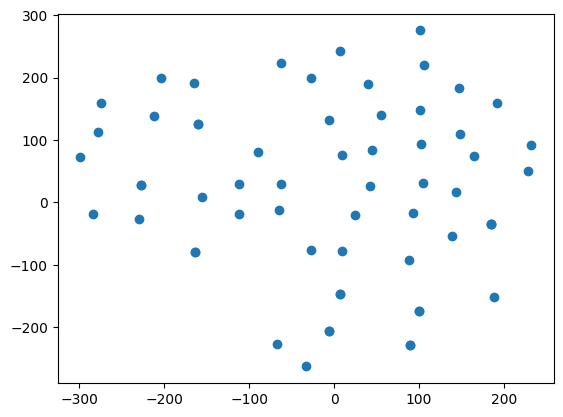

In [ ]:
plt.scatter(x,y)
plt.show()

# ISOMAP

In [12]:
from sklearn.manifold import Isomap

In [35]:
def plt_image(image, label):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(label)
    # Mostra i subplot affiancati
    plt.show()

In [52]:
n_neighbors = 12
n_components = 10

In [53]:
isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components, p=1)
datax = isomap.fit_transform(features)

In [55]:
datax.shape

(61, 10)

In [26]:
x=[e[0] for e in datax]
y=[e[1] for e in datax]

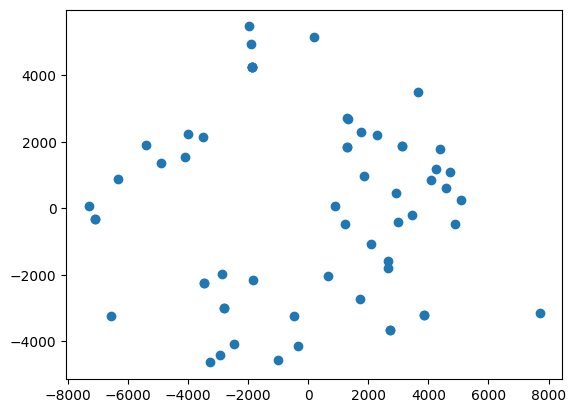

In [23]:
plt.scatter(x,y)
plt.show()

In [104]:
n_clusters = 4
kmeans = KMeans(n_clusters = n_clusters, random_state = 0, n_init='auto')
labels = kmeans.fit_predict(datax)

In [105]:
labels

array([2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       0, 2, 0, 2, 0, 2, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0,
       0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0], dtype=int32)

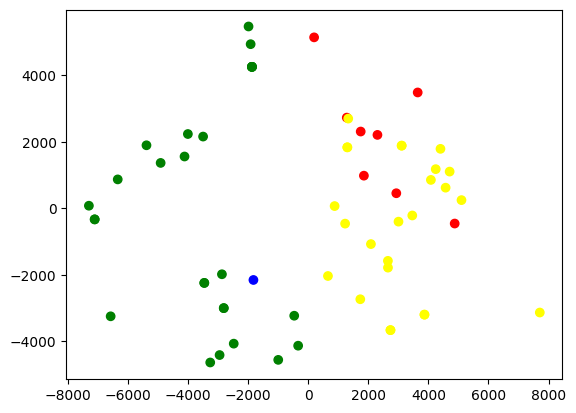

In [106]:
colors = ["red" , "yellow", "green", "blue", "purple", "orange"]

cc = [colors[label] for label in labels]

plt.scatter(x,y, c = cc)
plt.show()

In [107]:
maschera = np.where(labels == 1)
len(maschera[0])

25

In [114]:
def plot_images(images, labels):
    # Trovare il numero unico di etichette
    unique_labels = np.unique(labels)

    # Preparare una figura per ogni etichetta
    fig, axs = plt.subplots(8, len(unique_labels), figsize=(10,10))

    # Per ogni etichetta unica
    for i, label in enumerate(unique_labels):
        # Trovare le immagini corrispondenti a questa etichetta
        matching_images = images[labels == label]
        print(matching_images.shape)
        # Per ogni immagine corrispondente
        for j, image in enumerate(matching_images):
            if j>=8:
              break
            # Creare un subplot per l'immagine
            axs[j, i].imshow(image, cmap='gray')
            axs[j, i].axis('off')  # non mostrare gli assi


    plt.tight_layout()  # spaziatura automatica
    plt.show()  # visualizza la figura

(8, 189, 189, 3)
(25, 189, 189, 3)
(27, 189, 189, 3)
(1, 189, 189, 3)


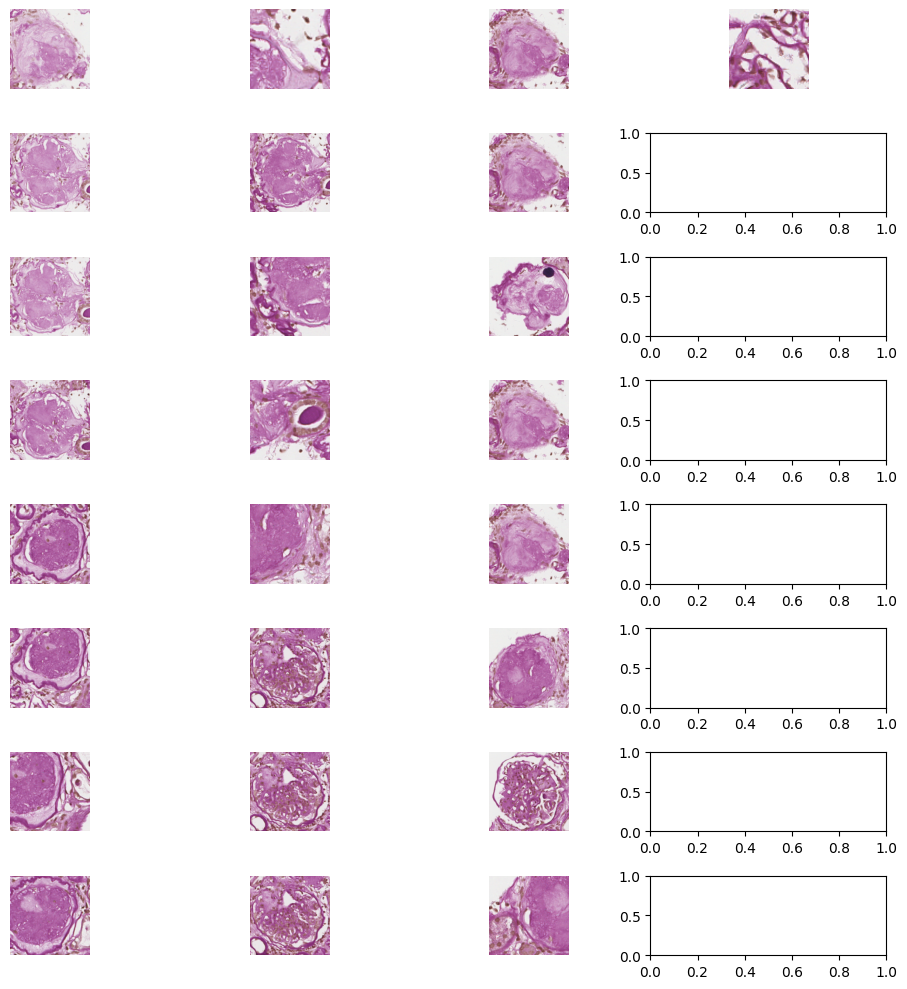

In [115]:
plot_images(result, labels)

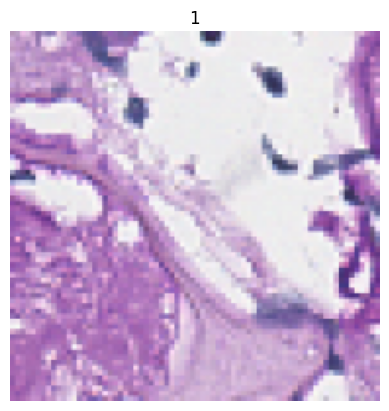

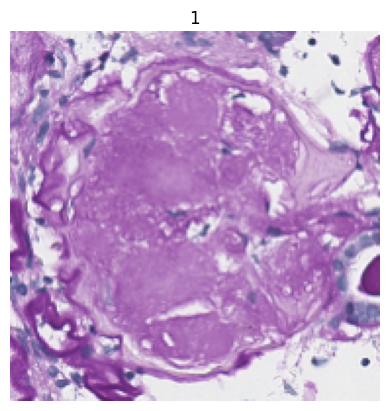

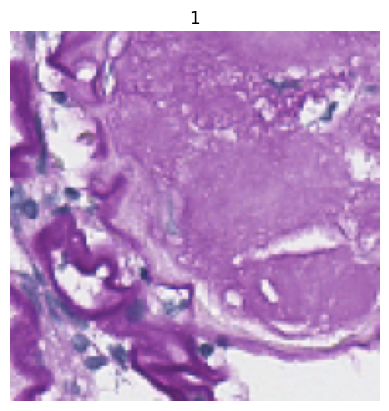

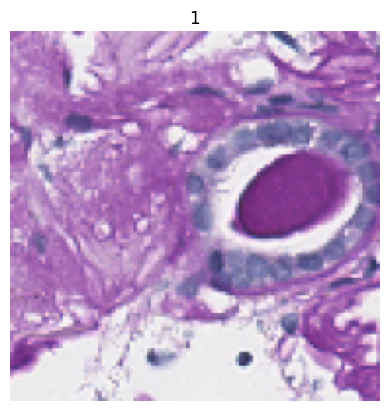

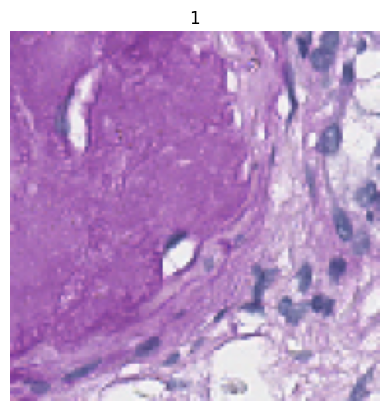

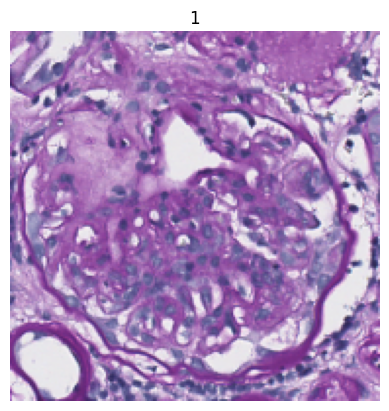

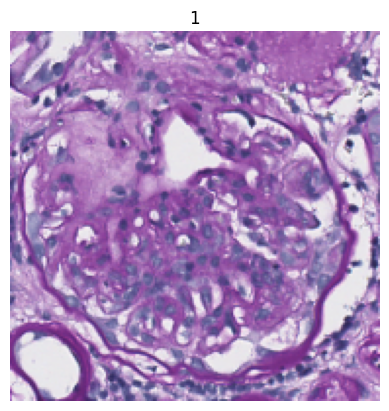

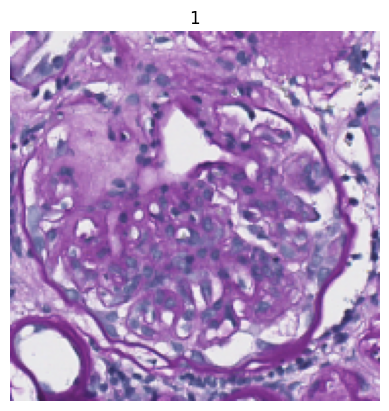

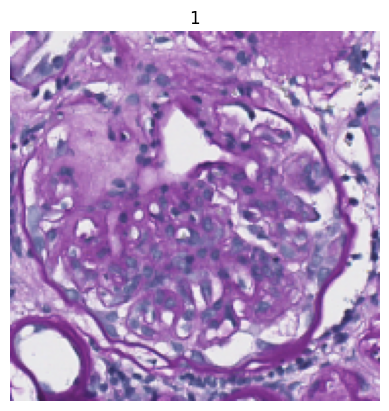

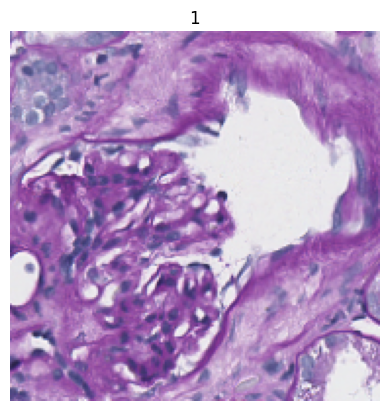

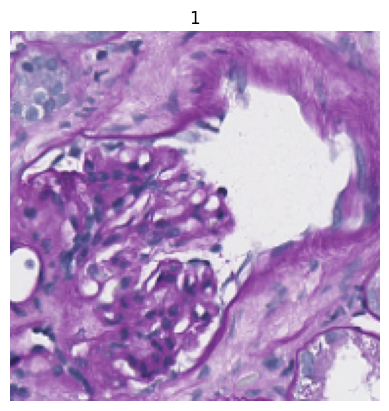

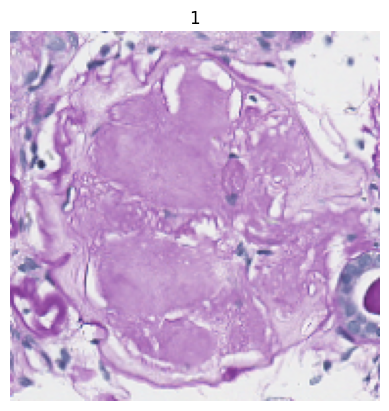

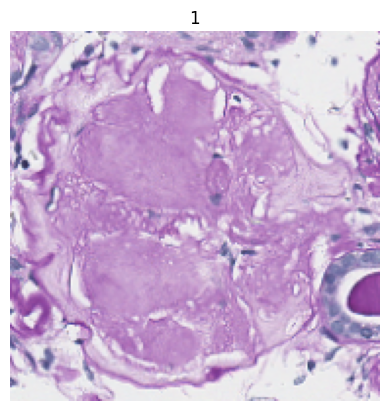

KeyboardInterrupt: ignored

In [103]:

for i in range(0, len(maschera[0])):
  plt_image(result[maschera[0][i]], labels[maschera[0][i]])